# Diabetes_Prediction_System

In [5]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostClassifier


import warnings  
warnings.filterwarnings('ignore')
import seaborn as sns 
import matplotlib.pyplot as plt  
%matplotlib inline 

In [4]:
import catboost

In [3]:
!pip install catboost

     ---------------------------------------- 73.9/73.9 MB 2.7 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB 2.5 MB/s eta 0:00:00


In [6]:
df = pd.read_csv("diabetes.csv") 
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [10]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [13]:
# ==================== Dividing the data into training and testing sets ==================
X = df.drop("Outcome", axis=1) 
y = df["Outcome"] 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)  

print("X-Training Shape:- ", X_train.shape) 
print("X-Testing Shape:- ", X_test.shape) 
print("y-Training Shape:- ", y_train.shape) 
print("y-Testing Shape:- ", y_test.shape)

X-Training Shape:-  (614, 8)
X-Testing Shape:-  (154, 8)
y-Training Shape:-  (614,)
y-Testing Shape:-  (154,)


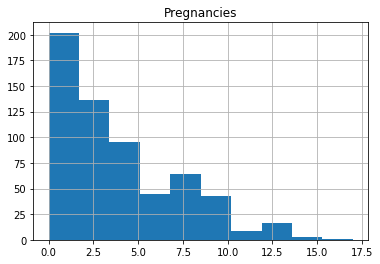

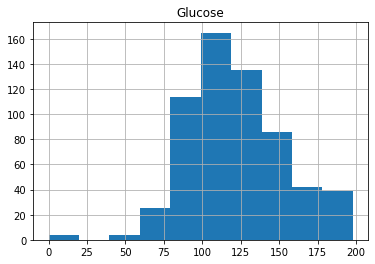

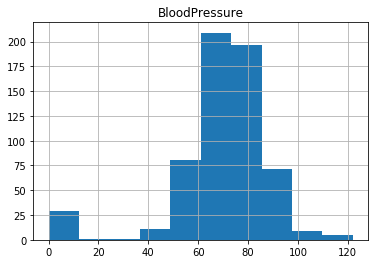

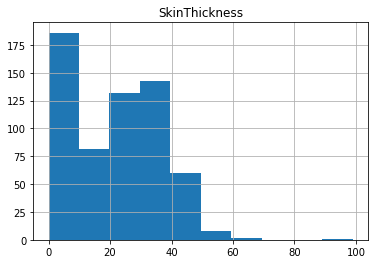

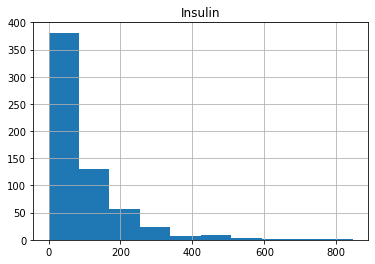

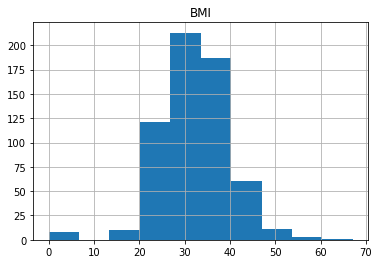

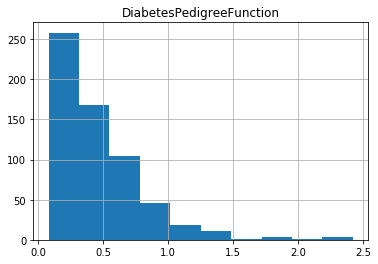

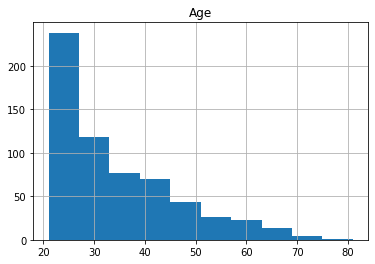

In [14]:
# ============================ Seeing the distribution of the data ======================
for col in X.columns:
    X_train.loc[:, col].hist()
    plt.title(col)
    plt.show()

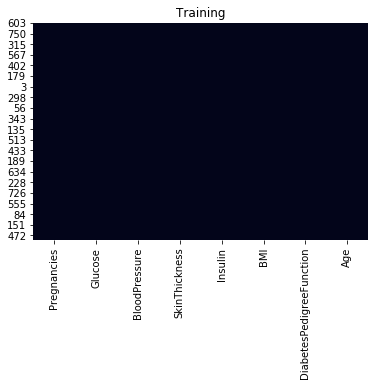

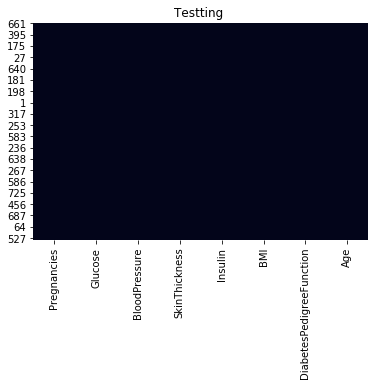

In [15]:
#  Checking Is there any null values in the training and testing sets? Ans = NO 
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

sns.heatmap(X_test.isnull(), cbar=False)
plt.title("Testting ")
plt.show()

## Building the model


In [17]:
def cindex(y_true, scores):  
    ''' 
    Function for evaluating the models 
    info:- 
     - The c-index measures the discriminatory power of a risk score.
     - A higher c-index indicates that the model's prediction is in agreement with the actual outcomes of a pair of patients.
     - cindex  = concordant + 0.5 x ties / permissible 
    '''
    n = len(y_true)
    assert len(scores) == n
    concordant = 0
    permissible = 0
    ties = 0
    for i in range(n):
        for j in range(i+1,n): 
            if y_true[i] != y_true[j]:
                permissible = permissible + 1
                if scores[i] == scores[j]:
                    ties = ties + 1
                    continue
                if y_true[i] == 0 and y_true[j] == 1:
                    if scores[i] < scores[j]:
                        concordant = concordant + 1  
                if y_true[i] == 1 and y_true[j] == 0:
                    if scores[i] > scores[j]:
                        concordant = concordant + 1

    c_index =  (concordant + (0.5 * ties)) / permissible
    return c_index

## Decision Tree Model

In [18]:
### ===================== Building the decision tree model ========================================= 

dtc_hyperparams = { 
    "max_depth":5,
    "min_samples_split" : 2
}
dtc = DecisionTreeClassifier(**dtc_hyperparams, random_state=10) 
dtc.fit(X_train, y_train) 

#  Evaluating using C-Index  

y_train_preds = dtc.predict_proba(X_train)[:, 1] 
y_test_preds = dtc.predict_proba(X_test)[:, 1] 

print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")
print(f"Val C-Index (expected > 0.6): {cindex(y_test.values, y_test_preds)}")

Train C-Index: 0.9059157426916744
Val C-Index (expected > 0.6): 0.8101014118114933


## Random Forest Model

In [19]:
# ==================== Baseline and Tuning the model  ================================== 

rfc = RandomForestClassifier() 

max_depth = [int(x) for x in np.linspace(5, 10, num = 2)] 
max_depth.append(None)

r_grid = {'n_estimators': [int(x) for x in np.linspace(start =80 , stop = 100, num = 10)],
        'max_features':  ['auto', 'log2'],
        'max_depth': max_depth,
        'bootstrap': [True, False]} 

rfr_random = RandomizedSearchCV(estimator=rfc, param_distributions=r_grid, n_iter = 20, scoring='accuracy', cv = 3, verbose=2, random_state=42, n_jobs=-1, return_train_score=True)

rfr_random.fit(X_train, y_train) 

print(rfr_random.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s


{'n_estimators': 84, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': False}


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.1s finished


In [20]:
# ========================= Building the model ==============================
rfc = RandomForestClassifier(n_estimators= 84, max_features= 'auto', max_depth= 5, bootstrap= False) 
rfc.fit(X_train, y_train) 

y_train_preds = rfc.predict_proba(X_train)[:, 1] 
y_test_preds = rfc.predict_proba(X_test)[:, 1] 

print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")
print(f"Val C-Index : {cindex(y_test.values, y_test_preds)}")

Train C-Index: 0.9431798556181133
Val C-Index : 0.8544442235036787


## XGboost Classifier Model

In [21]:
# ============================= Building model in XGboost ============================= 

eval_set  = [(X_test, y_test)]

xgb = XGBClassifier() 
xgb.fit(X_train, y_train,early_stopping_rounds=10, eval_metric="logloss",eval_set=eval_set, verbose=True) 

[0]	validation_0-logloss:0.59035
[1]	validation_0-logloss:0.54348
[2]	validation_0-logloss:0.50695
[3]	validation_0-logloss:0.47708
[4]	validation_0-logloss:0.46051
[5]	validation_0-logloss:0.44754
[6]	validation_0-logloss:0.44518
[7]	validation_0-logloss:0.44170
[8]	validation_0-logloss:0.44845
[9]	validation_0-logloss:0.44976
[10]	validation_0-logloss:0.45432
[11]	validation_0-logloss:0.45450
[12]	validation_0-logloss:0.46526
[13]	validation_0-logloss:0.46121
[14]	validation_0-logloss:0.46607
[15]	validation_0-logloss:0.46622
[16]	validation_0-logloss:0.46497
[17]	validation_0-logloss:0.46399


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [23]:
y_train_preds = xgb.predict_proba(X_train)[:, 1] 
y_test_preds = xgb.predict_proba(X_test)[:, 1] 

print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")
print(f"Val C-Index : {cindex(y_test.values, y_test_preds)}")

Train C-Index: 0.9734090935258425
Val C-Index : 0.8528534499900576


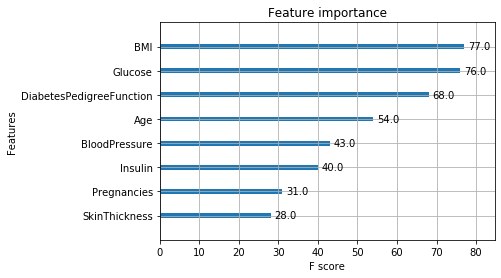

In [24]:
from xgboost import plot_importance
# xgb.feature_importances_ 
plot_importance(xgb)
plt.show()

In [25]:
# ------------------- Tuning the XGboost Model --------------------------------  

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
subsample = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
colsample_bytree = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0]

param_grid = dict(n_estimators=n_estimators, max_depth = max_depth,  learning_rate = learning_rate,
                subsample = subsample,
                colsample_bytree = colsample_bytree)  

grid_search = GridSearchCV(xgb, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=2, verbose=True)
grid_result = grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 7776 candidates, totalling 15552 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 2984 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 4784 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 6984 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 9584 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 12584 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 15552 out of 15552 | elapsed:  2.2min finished


In [26]:
grid_search.best_params_


{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 50,
 'subsample': 1.0}

In [27]:
xgb1 = XGBClassifier(colsample_bytree= 1.0,
 learning_rate = 0.1,
 max_depth = 2,
 n_estimators= 50,
 subsample= 1.0) 
xgb1.fit(X_train, y_train,early_stopping_rounds=10, eval_metric="logloss",eval_set=eval_set, verbose=True) 

[0]	validation_0-logloss:0.66251
[1]	validation_0-logloss:0.63719
[2]	validation_0-logloss:0.61532
[3]	validation_0-logloss:0.59829
[4]	validation_0-logloss:0.58238
[5]	validation_0-logloss:0.56748
[6]	validation_0-logloss:0.55432
[7]	validation_0-logloss:0.54424
[8]	validation_0-logloss:0.53491
[9]	validation_0-logloss:0.52695
[10]	validation_0-logloss:0.51756
[11]	validation_0-logloss:0.51101
[12]	validation_0-logloss:0.50440
[13]	validation_0-logloss:0.50115
[14]	validation_0-logloss:0.49598
[15]	validation_0-logloss:0.49251
[16]	validation_0-logloss:0.48846
[17]	validation_0-logloss:0.48349
[18]	validation_0-logloss:0.48076
[19]	validation_0-logloss:0.47888
[20]	validation_0-logloss:0.47599
[21]	validation_0-logloss:0.47258
[22]	validation_0-logloss:0.47085
[23]	validation_0-logloss:0.46814
[24]	validation_0-logloss:0.46846
[25]	validation_0-logloss:0.46639
[26]	validation_0-logloss:0.46259
[27]	validation_0-logloss:0.46172
[28]	validation_0-logloss:0.45991
[29]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [28]:
y_train_preds = xgb1.predict_proba(X_train)[:, 1] 
y_test_preds = xgb1.predict_proba(X_test)[:, 1] 

print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")
print(f"Val C-Index : {cindex(y_test.values, y_test_preds)}")

Train C-Index: 0.892415921154134
Val C-Index : 0.8450984291111553


## Catboost

In [29]:
catboost = CatBoostClassifier(iterations=50,
                             learning_rate=0.0001,
                             random_seed=42,
                            custom_loss=['AUC', 'Accuracy']) 
catboost.fit(X_train, y_train, eval_set = eval_set, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [30]:
y_train_preds = catboost.predict_proba(X_train)[:, 1] 
y_test_preds = catboost.predict_proba(X_test)[:, 1] 

print(f"Train C-Index: {cindex(y_train.values, y_train_preds)}")
print(f"Val C-Index : {cindex(y_test.values, y_test_preds)}")

Train C-Index: 0.8609604734436347
Val C-Index : 0.8492742095844105


## Saving the model
#### It seems like Catboost in more Robust as compare to other models, so we will save Catboost Classifier as our final model

In [31]:
import joblib 
joblib.dump(catboost, "model.pkl") 
model = joblib.load('model.pkl' ) 
model.predict(X_test)

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [32]:
obj = model.predict([[6,148,72,35,0,33.6,0.627,50]])


In [33]:
obj

array([1], dtype=int64)

In [34]:
joblib.dump(xgb1, "XGboost.pkl") 


['XGboost.pkl']